In [1]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv
load_dotenv();

In [34]:
import src.features.build_features as FeaturesManager
import src.visualization.visualize as VizManager
from src.models.HP_XGBoost import XGBoost_GridSearch, evaluate

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, roc_auc_score

import xgboost as xgb
from comet_ml import Experiment

import pickle
import os

In [6]:
# Loading data
seasons_year = [2015, 2016, 2017, 2018]
season_type = "Regular"
features_data_df = FeaturesManager.build_features(seasons_year, season_type)
features_data_df.head(5)

,Game ID,Event Index,Period,Team,Type,Shot Type,Shooter,Shooter ID,Shooter Side,Shooter Ice Position,...,Game seconds,Last event angle,Rebound,Change in Shot Angle,Speed From Previous Event,Shooter Goal Ratio Last Season,Goalie Goal Ratio Last Season,Num players With,Num players Against,Elapsed time since Power Play
0,2015020001,7,1,Toronto Maple Leafs (TOR),Shot,Wrist Shot,Brad Boyes,8468504,R,R,...,51,10.525108,0.0,0.000000,13.415281,0.092715,0.066564,5.0,5.0,0.0
1,2015020001,9,1,Toronto Maple Leafs (TOR),Shot,Snap Shot,Nazem Kadri,8475172,L,C,...,65,28.300756,0.0,0.000000,6.730362,0.102273,0.066564,5.0,5.0,0.0
2,2015020001,10,1,Toronto Maple Leafs (TOR),Shot,Snap Shot,Nazem Kadri,8475172,L,C,...,66,0.000000,1.0,4.085617,2.748737,0.102273,0.066564,5.0,5.0,0.0
3,2015020001,13,1,Toronto Maple Leafs (TOR),Shot,Wrist Shot,Daniel Winnik,8471476,L,L,...,113,-93.270488,0.0,0.000000,4.302988,0.092784,0.066564,5.0,5.0,0.0
4,2015020001,21,1,Toronto Maple Leafs (TOR),Shot,Tip-In,Joffrey Lupul,8470207,R,L,...,157,47.726311,0.0,0.000000,4.085855,0.103093,0.066564,5.0,5.0,0.0


# Q5.1 - Baseline XGBoost model

In [9]:
# Q5.1 - Baseline XGBoost model
experiment = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    project_name="xgboost-baseline",
    workspace="ift6758-a22-g08",
)
xgb_base_model = xgb.XGBClassifier()
X = features_data_df[["Shot distance", "Shot angle"]]
y = features_data_df["Is Goal"] == True
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipe = make_pipeline(StandardScaler(), xgb_base_model)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-a22-g08/xgboost-baseline/6eccc23d9c2e413696829d28928b118c



In [10]:
pipe.fit(X_train, y_train)

COMET WARNING: You must install graphviz to plot tree


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [15]:
# Evaluate test set performance
with experiment.train():
    train_preds = pipe.predict_proba(X_train)
    y_train_OH = np.array([~y_train, y_train]).T
    metrics = evaluate(y_train_OH, train_preds)
    experiment.log_metrics(metrics)
    
with experiment.validate():
    preds = pipe.predict_proba(X_test)
    y_test_OH = np.array([y_test == 0, y_test == 1]).T
    metrics = evaluate(y_test_OH, preds)
    experiment.log_metrics(metrics)

# Save model
pkl_filename = '../../models/XGBoost_baseline.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(pipe, file)
experiment.log_model("XGBoost_baseline", pkl_filename)
experiment.register_model("XGBoost_baseline")

experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-a22-g08/xgboost-baseline/6eccc23d9c2e413696829d28928b118c
COMET INFO:   Metrics:
COMET INFO:     train_accuracy     : 0.9066936942827873
COMET INFO:     train_macro f1     : 0.48078911909728606
COMET INFO:     train_precision    : 0.7773099039069029
COMET INFO:     train_recall       : 0.5025075173698172
COMET INFO:     train_rocauc       : 0.7398004187292149
COMET INFO:     validate_accuracy  : 0.9052900019616819
COMET INFO:     validate_macro f1  : 0.4789726267100205
COMET INFO:     validate_precision : 0.6682314740233588
COMET INFO:     validate_recall    : 0.5016683555961939
COMET INFO:     validate_rocauc    : 0.7141698685115223
COMET INFO:   Parameters:
COMET INFO:     begin_iteration                        : 0
COMET INFO:     end_i

In [20]:
print(classification_report(y_test, preds[:,1] > preds[:,0]))

              precision    recall  f1-score   support

       False       0.91      1.00      0.95     69232
        True       0.43      0.00      0.01      7233

    accuracy                           0.91     76465
   macro avg       0.67      0.50      0.48     76465
weighted avg       0.86      0.91      0.86     76465



# Q5.2 - Hyperparameter tuning

In [21]:
# Q5.2 - Hyperparameter tuning

# Load processed data
X_train, X_test, y_train, y_test = FeaturesManager.GetTrainValid()

/mnt/c/Users/mmrz3/Desktop/IFT6758/IFT6758-A2022-G08-master/src/features/build_features.py:409: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_features = df_features.fillna(df_features.median())


In [22]:
# Only use the features that were actually mentioned in Q4
X_train = X_train[['Period seconds', 'Period', 'st_X', 'st_Y', 'Shot distance', 'Shot angle', 'Shot_Type_Backhand', 'Shot_Type_Deflected', 'Shot_Type_Slap Shot', 'Shot_Type_Snap Shot', 'Shot_Type_Tip-In', 'Shot_Type_Wrap-around', 'Shot_Type_Wrist Shot', 'Last event st_X', 'Last event st_Y', 'Last event elapsed time', 'Last event distance', 'Rebound', 'Change in Shot Angle', 'Speed From Previous Event']]
X_test = X_test[['Period seconds', 'Period', 'st_X', 'st_Y', 'Shot distance', 'Shot angle', 'Shot_Type_Backhand', 'Shot_Type_Deflected', 'Shot_Type_Slap Shot', 'Shot_Type_Snap Shot', 'Shot_Type_Tip-In', 'Shot_Type_Wrap-around', 'Shot_Type_Wrist Shot', 'Last event st_X', 'Last event st_Y', 'Last event elapsed time', 'Last event distance', 'Rebound', 'Change in Shot Angle', 'Speed From Previous Event']]

In [ ]:
grid_search, X_test = XGBoost_GridSearch(X_train, X_test, y_train, y_test)

In [24]:
grid_search.best_params_

{'gamma': 6, 'learning_rate': 0.1, 'max_depth': 8}

In [30]:
experiment = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    project_name="best-models",
    workspace="ift6758-a22-g08",
)
experiment.set_name('XGBoost_HPSearch')

with experiment.train():
    train_preds = grid_search.predict_proba(X_train)
    y_train_OH = np.array([y_train == 0, y_train == 1]).T
    metrics = evaluate(y_train_OH, train_preds)
    experiment.log_metrics(metrics)

# Evaluate test set performance
with experiment.validate():
    preds = grid_search.predict_proba(X_test)
    y_test_OH = np.array([y_test == 0, y_test == 1]).T
    metrics = evaluate(y_test_OH, preds)
    experiment.log_metrics(metrics)

# Save model
pkl_filename = '../../models/XGBoost_HPSearch.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(grid_search, file)
experiment.log_model("XGBoost_HPSearch", pkl_filename)
experiment.register_model("XGBoost_HPSearch")

experiment.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-a22-g08/best-models/7568d5e2d62d4528a7e1943e8efe2836
COMET INFO:   Others:
COMET INFO:     Name : XGBoost_HPSearch
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (558.89 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages              : 1
COMET INFO:     source_code              : 1
COMET

In [32]:
print(classification_report(y_test, preds[:,1] > preds[:,0]))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     55434
         1.0       0.65      0.03      0.06      5738

    accuracy                           0.91     61172
   macro avg       0.78      0.52      0.51     61172
weighted avg       0.88      0.91      0.87     61172



# Q5.3 - Feature selection

In [35]:
# Q5.3 - Feature selection

# Refetch & scale data
X_train, X_test, y_train, y_test = FeaturesManager.GetTrainValid()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/mnt/c/Users/mmrz3/Desktop/IFT6758/IFT6758-A2022-G08-master/src/features/build_features.py:409: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_features = df_features.fillna(df_features.median())


In [36]:
from sklearn.feature_selection import SelectKBest, RFECV, SequentialFeatureSelector
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [37]:
# SelectKBest with HP search on scoring functions and k-values
def KBest():
    max_score = 0
    max_selector = None
    for scoring in [chi2, f_classif, mutual_info_classif]:
        for k in [5, 10, 15, 20]:
            experiment = Experiment(
                api_key=os.environ.get('COMET_API_KEY'),
                project_name="feature-selection-xgboost",
                workspace="ift6758-a22-g08",
                display_summary_level=0
            )
            experiment.set_name(f"SelectKBest_HPSearch_k={k}_scoring={str(scoring).split()[1]}")
            selector = SelectKBest(scoring, k=k)
            pipe = Pipeline([
                ('feature_selection', SelectKBest(scoring, k=k)),
                ('classification', xgb.XGBClassifier())
            ])
            score = cross_validate(pipe, X_train, y_train, cv=5, scoring='roc_auc', error_score='raise')['test_score'].mean()
            experiment.log_metric("roc_auc score", score)
            experiment.log_parameters(pipe.get_params())
            if score > max_score:
                max_score = score
                max_selector = selector
            experiment.end()

    # Save model
    model = Pipeline([
                ('feature_selection', max_selector),
                ('classification', xgb.XGBClassifier())
            ])
    pkl_filename = '../../models/XGBoost_SelectKBest.pkl'
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)
    experiment.log_model("XGBoost_SelectKBest", pkl_filename)
    experiment.register_model("XGBoost_SelectKBest")
    
    return max_score, model

In [38]:
# Recursive feature elimination
def recursive():
    experiment = Experiment(
        api_key=os.environ.get('COMET_API_KEY'),
        project_name="feature-selection-xgboost",
        workspace="ift6758-a22-g08",
        display_summary_level=0
    )
    experiment.set_name(f"RFECV")
    selector = RFECV(xgb.XGBClassifier(), cv=5)
    score = cross_validate(selector, X_train, y_train, cv=5, scoring='roc_auc', error_score='raise')['test_score'].mean()
    experiment.log_metric("ROC-AUC score - Cross-Validation", score)
    experiment.log_parameters(selector.get_params())
    
    # Save model
    pkl_filename = '../../models/XGBoost_RFECV.pkl'
    with open(pkl_filename, 'wb') as file:
        pickle.dump(selector, file)
    experiment.log_model("XGBoost_RFECV", pkl_filename)
    experiment.register_model("XGBoost_RFECV")
    
    experiment.end()
    return score, selector

In [58]:
# Sequential feature selection
def sequential():
    max_score = 0
    max_selector = None
    for k in [5, 10, 15, 20]:
        experiment = Experiment(
            api_key=os.environ.get('COMET_API_KEY'),
            project_name="feature-selection-xgboost",
            workspace="ift6758-a22-g08",
            display_summary_level=0
        )
        experiment.set_name(f"SequentialFeatureSelection_k={k}")
        selector = SequentialFeatureSelector(xgb.XGBClassifier(), n_features_to_select=k)
        pipe = Pipeline([
            ('feature_selection', selector),
            ('classification', xgb.XGBClassifier())
        ])
        X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train)
        pipe.fit(X_tr, y_tr)
        y_val = np.array([y_val == 0, y_val == 1]).T
        score = roc_auc_score(y_val, pipe.predict_proba(X_val))
        # score = cross_validate(pipe, X_train, y_train, cv=5, scoring='roc_auc', error_score='raise')['test_score'].mean()
        experiment.log_metric("roc_auc score", score)
        # experiment.log_parameters(pipe.get_params())
        if score > max_score:
            max_score = score
            max_selector = selector
        experiment.end()
   
    # Save model
    experiment = Experiment(
        api_key=os.environ.get('COMET_API_KEY'),
        project_name="feature-selection-xgboost",
        workspace="ift6758-a22-g08",
    )
    experiment.set_name(f"SequentialFeatureSelection_Evaluation")
    model = Pipeline([
        ('feature_selection', max_selector),
        ('classification', xgb.XGBClassifier())
    ])
    pkl_filename = '../../models/XGBoost_Sequential.pkl'
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)
    experiment.log_model("XGBoost_Sequential", pkl_filename)
    experiment.register_model("XGBoost_Sequential")
    
    experiment.end()
    return max_score, model

In [105]:
# Random Forest feature selection
def random_forest():
    experiment = Experiment(
        api_key=os.environ.get('COMET_API_KEY'),
        project_name="feature-selection-xgboost",
        workspace="ift6758-a22-g08",
        display_summary_level=0
    )
    experiment.set_name(f"RandomForestSelection")
    selector = SelectFromModel(RandomForestClassifier(random_state=0), prefit=False)
    classifier = xgb.XGBClassifier()
    pipe = Pipeline([
        ('feature_selection', selector),
        ('classification', classifier)
    ])
    score = cross_validate(pipe, X_train, y_train, cv=5, scoring='roc_auc', error_score='raise')['test_score'].mean()
    experiment.log_metric("roc_auc score", score)
    pipe.fit(X_train, y_train) # fit on all train data before returning
    # experiment.log_parameters(pipe.get_params())
    
    # Save model
    pkl_filename = '../../models/XGBoost_RandomForest.pkl'
    with open(pkl_filename, 'wb') as file:
        pickle.dump(pipe, file)
    experiment.log_model("XGBoost_RandomForest", pkl_filename)
    experiment.register_model("XGBoost_RandomForest")
    
    experiment.end()
    return score, pipe

In [53]:
# Try all feature selection methods and compare on validation score
def feature_selection():
    max_score = 0
    best_model = None
    best_method = None
    for method in [KBest, recursive, sequential, random_forest]:
        score, model = method()
        if score > max_score:
            max_score = score
            best_model = model
            best_method = method
    return max_score, best_model, str(best_method).split()[1]

In [ ]:
max_score, best_model, method_name = feature_selection()

In [64]:
max_score, method_name

(0.7760886481003134, 'random_forest')

In [ ]:
# Important features
# _, test_data, _, _ = FeaturesManager.GetTrainValid()
importances = best_model.named_steps.feature_selection.estimator_.feature_importances_
test_data[:, importances > importances.mean()]

In [111]:
# Evaluate test set performance
experiment = Experiment(
        api_key=os.environ.get('COMET_API_KEY'),
        project_name="best-models",
        workspace="ift6758-a22-g08",
)
experiment.set_name(f"XGBoost_FeatureSelection_{method_name}")

with experiment.train():
    train_preds = best_model.predict_proba(X_train)
    y_train_OH = np.array([y_train == 0, y_train == 1]).T
    metrics = evaluate(y_train_OH, train_preds)
    experiment.log_metrics(metrics)

with experiment.validate():
    preds = best_model.predict_proba(X_test)
    y_test_OH = np.array([y_test == 0, y_test == 1]).T
    metrics = evaluate(y_test_OH, preds)
    experiment.log_metrics(metrics)

# Save model
pkl_filename = '../../models/XGBoost_FeatureSelection_Best.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(pipe, file)
experiment.log_model(f"XGBoost_FeatureSelection_{method_name}", pkl_filename)
experiment.register_model(f"XGBoost_FeatureSelection_{method_name}")

experiment.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-a22-g08/best-models/91e6d54cfd5e4d438115f08b4597c677

COMET INFO: Successfully registered 'xgboost-featureselection-random-forest', version '1.0.0' in workspace 'ift6758-a22-g08'
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-a22-g08/best-models/91e6d54cfd5e4d438115f08b4597c677
COMET INFO:   Metrics:
COMET INFO:  

# Generate Figures

In [ ]:
# 3D grid

In [ ]:
# Bar charts - ROC-AUC and F1

/mnt/c/Users/mmrz3/Desktop/IFT6758/IFT6758-A2022-G08-master/src/features/build_features.py:409: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_features = df_features.fillna(df_features.median())


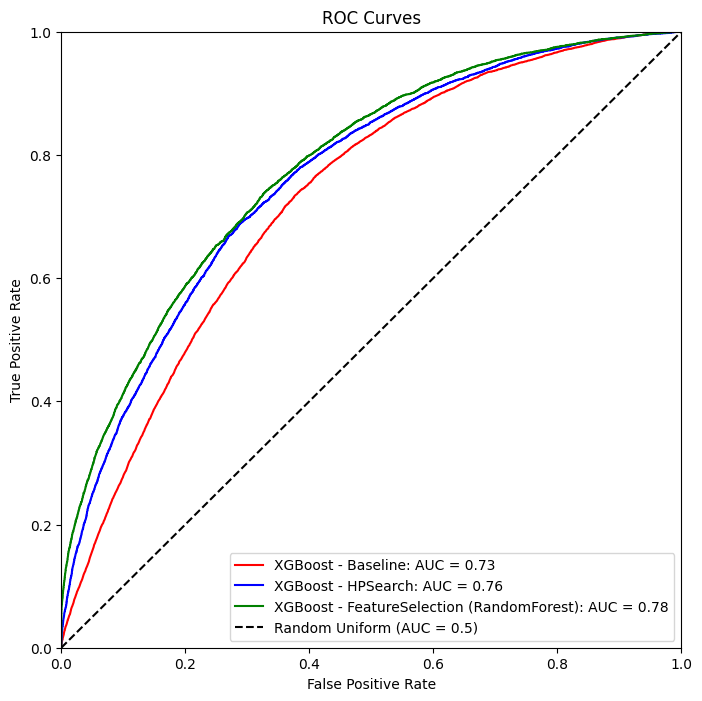

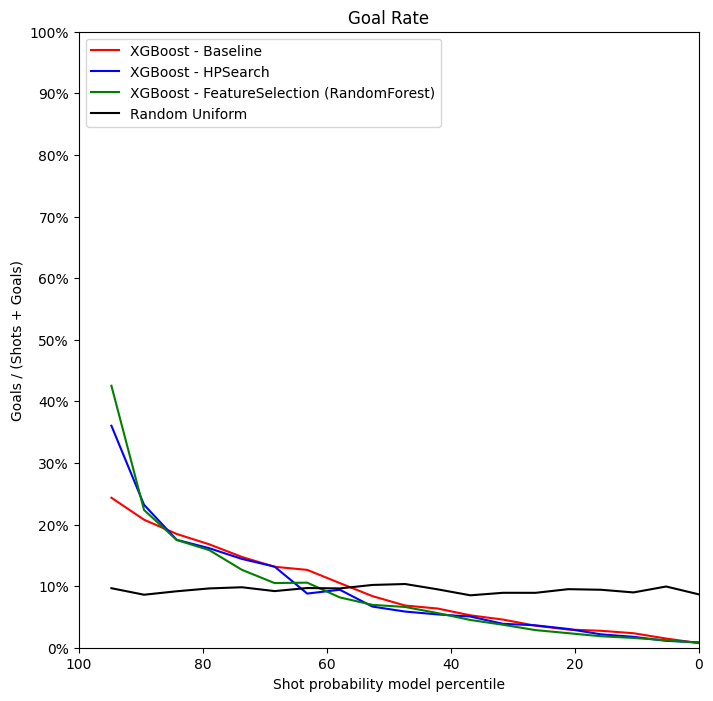

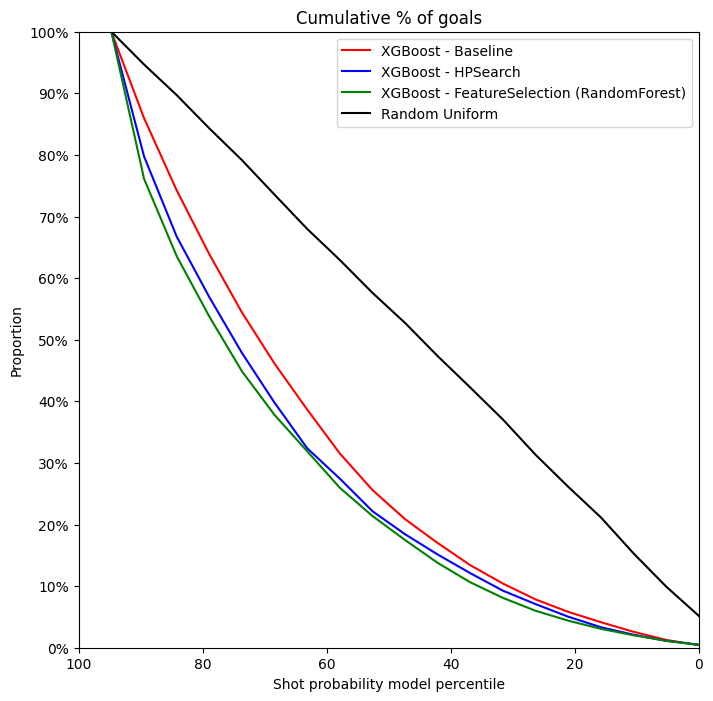

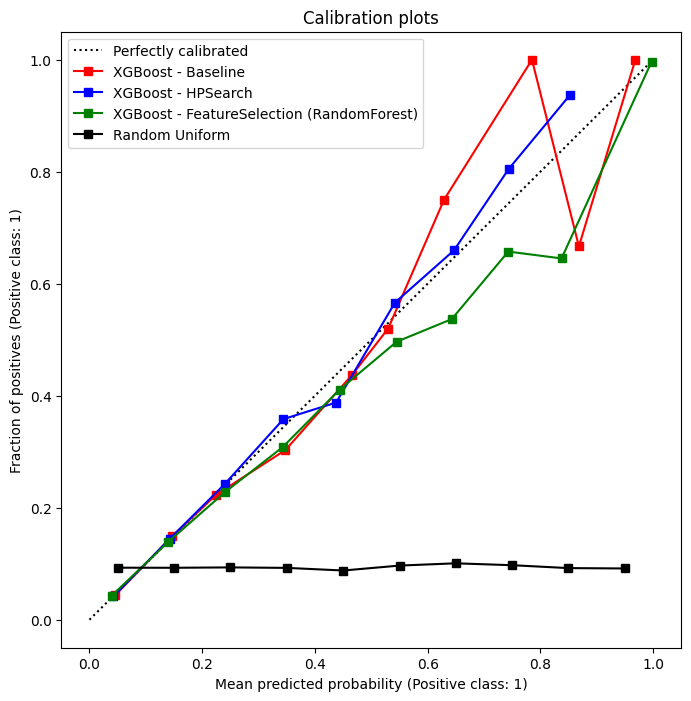

In [133]:
# 4 plots
_, X_test_baseline, _, y_test_baseline = train_test_split(X, y)
X_train_HPSearch, X_test_HPSearch, _, _ = FeaturesManager.GetTrainValid()
X_train_HPSearch = X_train_HPSearch[['Period seconds', 'Period', 'st_X', 'st_Y', 'Shot distance', 'Shot angle', 'Shot_Type_Backhand', 'Shot_Type_Deflected', 'Shot_Type_Slap Shot', 'Shot_Type_Snap Shot', 'Shot_Type_Tip-In', 'Shot_Type_Wrap-around', 'Shot_Type_Wrist Shot', 'Last event st_X', 'Last event st_Y', 'Last event elapsed time', 'Last event distance', 'Rebound', 'Change in Shot Angle', 'Speed From Previous Event']]
X_test_HPSearch = X_test_HPSearch[['Period seconds', 'Period', 'st_X', 'st_Y', 'Shot distance', 'Shot angle', 'Shot_Type_Backhand', 'Shot_Type_Deflected', 'Shot_Type_Slap Shot', 'Shot_Type_Snap Shot', 'Shot_Type_Tip-In', 'Shot_Type_Wrap-around', 'Shot_Type_Wrist Shot', 'Last event st_X', 'Last event st_Y', 'Last event elapsed time', 'Last event distance', 'Rebound', 'Change in Shot Angle', 'Speed From Previous Event']]
standard_scaler = StandardScaler()
standard_scaler.fit(X_train_HPSearch)
X_test_HPSearch = standard_scaler.transform(X_test_HPSearch)

VizManager.plot_all_figures(
    [
        (pipe, 'XGBoost - Baseline', X_test_baseline[["Shot distance", "Shot angle"]], y_test_baseline),
        (grid_search, 'XGBoost - HPSearch', X_test_HPSearch, y_test),
        (best_model, 'XGBoost - FeatureSelection (RandomForest)', X_test, y_test),
    ], 'xgboost'
)